In [3]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import numpy as np
import time
import pandas as pd
import random
from pyomo import environ as pe
import os
import matplotlib.pyplot as plt
import networkx as nx
os.environ['NEOS_EMAIL'] = 'XXXX@gmail.com' 

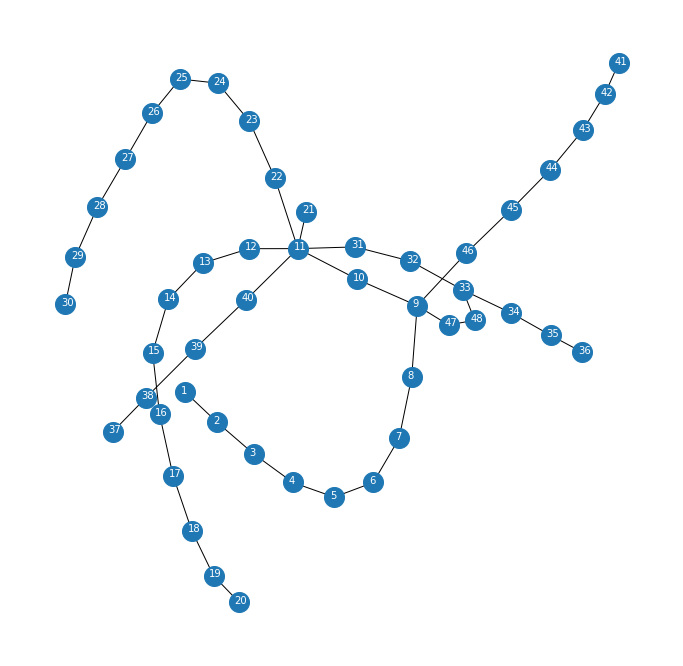

In [5]:
link, loc = {}, {}
p1 = range(1,20+1) # green
p2 = range(22,30+1) # green
p3 = range(31,36+1) # green
p4 = range(37,40+1) # green
p5 = range(41,46+1) # green


def edge_create(link,p):
    
    for i in range(len(p)):
        if i<len(p)-1:
            link[p[i],p[i+1]]=1
    return link

edge_create(link,p1)
edge_create(link,p2)
edge_create(link,p3)
edge_create(link,p4)
edge_create(link,p5)



link[11,22] = 1
link[11,21] = 1

link[11,40] = 1
link[11,31] = 1

link[9,46] = 1
link[9,47] = 1


link[47,48] = 1
link[33,48] = 1

plt.figure(figsize=(12,12))

G = nx.Graph()
allowed={}
for (v1,v2) in link:
    allowed[v1,v2] =1
    allowed[v2,v1] =1
    G.add_edge(v1, v2)

pos = nx.spring_layout(G, seed=1400, scale=5)  # positions for all nodes - seed for reproducibility

for v in G.nodes():
    loc[v,'x'] = pos[v][0]
    loc[v,'y'] = pos[v][1]
    
for v in G.nodes():
    x1,y1 = pos[v][0],pos[v][1]
    plt.text(x1-0.07,y1-0.01, str(v), c='w')

nx.draw(G, pos=pos, node_size=400, font_weight='bold')
plt.show()


In [19]:
N = len(G.nodes())
model = AbstractModel()
model.i = RangeSet(N)
model.j = Set(initialize=model.i)
model.k = RangeSet(90)
model.U = Var(model.i,model.j, model.k,bounds=(0,1), within = Binary)
model.start = Var(model.i, within = Binary)
model.ent = Var(model.i,model.k,bounds=(0,1), within = Reals)
model.out = Var(model.i,model.k,bounds=(0,1), within = Reals)
#model.finish = Var(model.k,bounds=(0,1), within = Binarymodel.finish = Var(model.k,bounds=(0,1), within = Binary")

def rule_C4(model): 
    return sum(model.start[i] for i in model.i) == 1
model.C4 = Constraint(rule=rule_C4)

def rule_C6(model,k):
    if k <=N:
        return sum(model.U[i,j,k] for (i,j) in allowed) == 1
    else:
        return sum(model.U[i,j,k] for (i,j) in allowed) <= 1
model.C6 = Constraint(model.k, rule=rule_C6)

def rule_C7A(model,i,k):
    return model.out[i,k] == sum(model.U[i,j,k] for j in model.j if (i,j) in allowed)
model.C7A = Constraint(model.i, model.k, rule=rule_C7A)

def rule_C7B(model,i,k):
    return model.ent[i,k] == sum(model.U[j,i,k] for j in model.j if (j,i) in allowed)
model.C7B = Constraint(model.i, model.k, rule=rule_C7B)

def rule_C8(model,i): 
    return model.start[i]+ sum(model.ent[i,k] for k in model.k) >= 1
model.C8 = Constraint(model.i, rule=rule_C8)

def rule_C9(model,i,k):
    if k >1:
        return model.out[i,k] <= model.ent[i,k-1]
    else:
        return Constraint.Skip
model.C9 = Constraint(model.i,model.k, rule=rule_C9)

def rule_C10(model,i):
    return model.out[i,1] == model.start[i] 
model.C10 = Constraint(model.i, rule=rule_C10)

def rule_C11(model,i,j,k):
    if (i,j) in allowed:
        return model.U[i,j,k] <= model.out[i,k]
    else:
        return Constraint.Skip 
model.C11 = Constraint(model.i,model.j,model.k, rule=rule_C11)

def rule_of(model):
    return sum(k*(random.random()*0.01+1)*model.U[i,j,k] for i in model.i for j in model.j for k in model.k if (i,j) in allowed )
    #return sum(k*model.finish[k] for k in model.k)

In [20]:
model.obj = Objective(rule=rule_of, sense=minimize)
instance = model.create_instance()
for k in instance.k:
    if k <= N:
        pass
        # instance.finish.fix(1)
        
for i in instance.i:
    instance.start[i].fix(0)
instance.start[30].fix(1)
    
opt = SolverFactory('cbc')
#opt.options = {'sec': 900, 'threads': 4, 'ratio': 0.02}
opt.options = {'sec': 1800, 'threads': 4, 'ratio': 0.04}

#opt = pe.SolverManagerFactory('neos')
#results = opt.solve(instance, solver = "cplex", options={'mipgap':0.15})
results = opt.solve(instance)  

    containing a solution


i = 78 
a= sum(value(instance.U[i,j]) for j in instance.j if (i,j) in allowed) + value(instance.final[i])
       
       
b = value(instance.start[i]) + sum(value(instance.U[j,i]) for j in instance.j if (j,i) in allowed)
print(a,b, value(instance.start[i]), value(instance.final[i]))

line (1, 30, 29)
line (2, 29, 28)
line (3, 28, 27)
line (4, 27, 26)
line (5, 26, 25)
line (6, 25, 24)
line (7, 24, 23)
line (8, 23, 22)
line (9, 22, 11)
line (10, 11, 21)
line (11, 21, 11)
line (12, 11, 31)
line (13, 31, 32)
line (14, 32, 33)
line (15, 33, 48)
line (16, 48, 33)
line (17, 33, 34)
line (18, 34, 35)
line (19, 35, 36)
line (20, 36, 35)
line (21, 35, 34)
line (22, 34, 33)
line (23, 33, 48)
line (24, 48, 47)
line (25, 47, 9)
line (26, 9, 8)
line (27, 8, 7)
line (28, 7, 6)
line (29, 6, 5)
line (30, 5, 4)
line (31, 4, 3)
line (32, 3, 2)
line (33, 2, 1)
line (34, 1, 2)
line (35, 2, 3)
line (36, 3, 4)
line (37, 4, 5)
line (38, 5, 6)
line (39, 6, 7)
line (40, 7, 8)
line (41, 8, 9)
line (42, 9, 46)
line (43, 46, 45)
line (44, 45, 44)
line (45, 44, 43)
line (46, 43, 42)
line (47, 42, 41)
line (48, 41, 42)
line (49, 42, 43)
line (50, 43, 44)
line (51, 44, 45)
line (52, 45, 46)
line (53, 46, 9)
line (54, 9, 10)
line (55, 10, 11)
line (56, 11, 31)
line (57, 31, 11)
line (58, 11, 40)
l

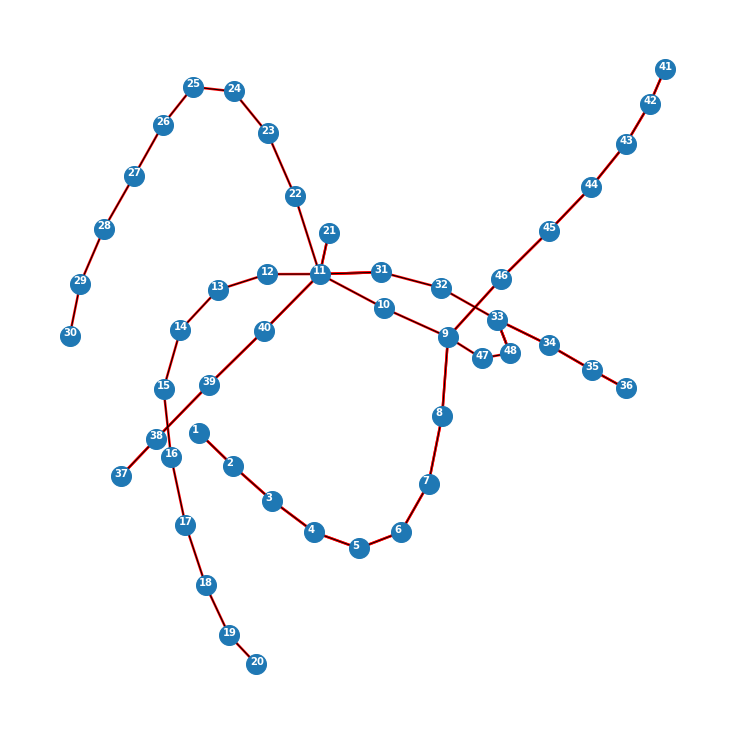

In [21]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd",
            "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf",
            "#aec7e8", "#ffbb78", "#98df8a", "#ff9896", "#c5b0d5",
            "#c49c94", "#f7b6d2", "#c7c7c7", "#dbdb8d", "#9edae5",
            "#8c6d31", "#9c9ede", "#637939", "#e7cb94", "#b5cf6b",
            "#cedb9c", "#c7c7c7", "#bd9e39", "#e7969c", "#7b4173"]

plt.figure(figsize=(10,10))
nx.draw(G, pos=pos, node_size= 400,  font_color='k')
for k in instance.k:
    # print(k,value(instance.finish[k]))
    for (i,j) in allowed:
        if value(instance.U[i,j,k])>0:
            x1,y1 = loc[i,'x'], loc[i,'y']
            x2,y2 = loc[j,'x'], loc[j,'y']
            plt.plot([x1,x2],[y1,y2], lw=2.5 , c='r', zorder=-2)
            print('line', (k,i,j))
for i in instance.i:
    x1,y1 = loc[i,'x'], loc[i,'y']
    plt.text(x1-0.1,y1, s=str(i) , fontweight='bold', fontsize=10, c='w')
    if value(instance.start[i])>0:
        print('start' ,i)

75

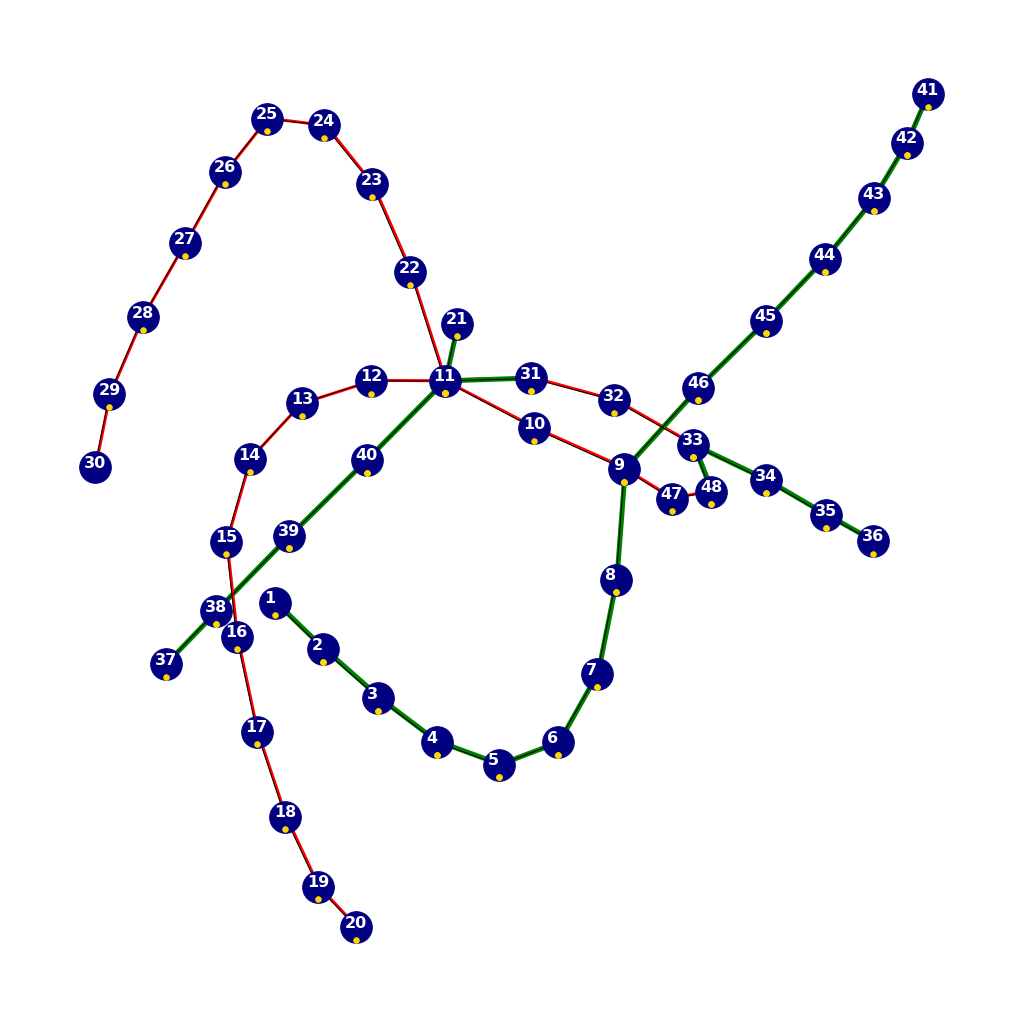

In [32]:
plt.figure(figsize=(14,14))
nx.draw(G, pos=pos,node_size=1000, node_color='navy')

St = int(sum(i*value(instance.start[i]) for i in instance.i))
counter =1
seen= {}

for i in instance.i:
    x1,y1 = loc[i,'x'], loc[i,'y']
    plt.text(x1-0.12,y1, s=str(i) , fontweight='bold', fontsize=16, c='w')    
    
for k in instance.k:
    for (i,j) in allowed:
        if value(instance.U[i,j,k])>0 and (j,i) in seen:
            x1,y1 = loc[i,'x'] + 0.01, loc[i,'y']+ 0.01*random.random()
            x2,y2 = loc[j,'x']+ 0.01, loc[j,'y']+ 0.01*random.random()
            kolor='g'
            plt.plot([x1,x2],[y1,y2], lw=5 , c=kolor, zorder=-2)
            plt.scatter(loc[j,'x'],loc[j,'y']-0.1, s=30, c='gold', zorder=2)
            plt.savefig(f'Route number {counter} .png', format='png', dpi=400)
            counter+=1
            seen[i,j] =1
        elif value(instance.U[i,j,k])>0 and (j,i) not in seen:
            x1,y1 = loc[i,'x'] + 0.01, loc[i,'y']+ 0.01*random.random()
            x2,y2 = loc[j,'x']+ 0.01, loc[j,'y']+ 0.01*random.random()
            kolor='r'
            plt.plot([x1,x2],[y1,y2], lw=3 , c=kolor, zorder=-2)
            plt.scatter(loc[j,'x'],loc[j,'y']-0.1, s=30, c='gold', zorder=2)
            plt.savefig(f'Route number {counter} .png', format='png', dpi=400)
            counter+=1
            seen[i,j] =1
counter